In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
from tqdm import tqdm
import seaborn as sns

In [59]:
def effective_prey(S, M, V):
    T = M + V # Total prey at each phenotype
    return T[None, None, :, :] * S

def predation_matrix(S, effective_prey, R, a=1, h=0.5, c=0.1):
    D = a * effective_prey / (1 
          + c * np.sum(effective_prey, axis=(0, 1))[None, None, :, :]
          + a*h*(R + effective_prey.sum(axis = (2, 3))[:, :, None, None]))
    return D

def update_predators(P, M, V, R, D, v, a, h, c, effective_prey, eta=0.85, d=0.2, mr=0.001, cutoff=1e-6, dt=0.01):

    T = M + V
    v_adj = V * v / T # adjusted venomosity at given phenotype
    v_adj = np.nan_to_num(v_adj)[None, None, :, :]

    # contribution from M, V
    dP = (D * (eta * (1 - v_adj) - v_adj)).sum(axis=(2,3)) - P * d

    # contribution from R
    Np = np.sum(P)
    dP += eta * P * a * R / (1 
                             + c * Np 
                             + a*h*(R + effective_prey.sum(axis = (2, 3))))
    
    # assert np.all(~np.isnan(prey_eaten))
    # assert np.all(~np.isnan(v_adj))
    # assert np.all(~np.isnan(dP))

    P_new = P + dP * dt
    P_new[P_new < cutoff] = 0

    P_new = mutate_phenotype(P_new, mr, dt)
    
    return P_new

def update_prey(V, M, D, r=1, K=1000, mr=0.01, cutoff=1e-6, dt=0.01):

    T = M + V
    pv = V / T
    pv = np.nan_to_num(pv)
    pm = M / T
    pm = np.nan_to_num(pm)
    
    predation = D.sum(axis=(0, 1))

    dV = V * r * (1 - np.sum(V) / K) - predation * pv
    dM = M * r * (1 - np.sum(M) / K) - predation * pm

    V = V + dV * dt
    V[V < cutoff] = 0
    V = mutate_phenotype(V, mr, dt)

    M = M + dM * dt
    M[M < cutoff] = 0
    M = mutate_phenotype(M, mr, dt)

    return V, M

def update_R(R, P, r, K, effective_prey, a, h, c, cutoff=1e-6, dt=0.01):
    Np = np.sum(P)
    dR_i = - P * a * R / (1 
                  + c * Np 
                  + a*h*(R + effective_prey.sum(axis = (2, 3))))
    dR = np.sum(dR_i)
    # assert not np.isnan(dR), dR_i
    dR += R * r * (1 - R / K)
    R_new = R + dR * dt
    if R_new < cutoff:
        return 0
    else:
        return R_new

def torus_mat(A):
    L = len(A)
    A_padded = np.zeros((L+2, L+2))
    A_padded[1:L+1, 1:L+1] = A
    A_padded[L+1, 1:L+1] = A[0]
    A_padded[0, 1:L+1] = A[L-1]
    A_padded[1:L+1, 0] = A[:,L-1]
    A_padded[1:L+1, L+1] = A[:,0]
    return A_padded
    

def mutate_phenotype(A, mr, dt):

    L = len(A)
    A_padded = torus_mat(A)
    Tx = mr * np.random.normal(0, dt**0.5, size=(L, L))
    Tx_padded = torus_mat(Tx)
    Ty = mr * np.random.normal(0, dt**0.5, size=(L, L))
    Ty_padded = torus_mat(Ty)
    dx_down = Tx_padded * A_padded
    dy_down = Ty_padded * A_padded

    # Tx = mr * np.random.normal(0, dt**0.5, size=(L, L))
    # Tx_padded = torus_mat(Tx)
    # Ty = mr * np.random.normal(0, dt**0.5, size=(L, L))
    # Ty_padded = torus_mat(Ty)
    # dx_up = Tx_padded * A_padded
    # dy_up = Ty_padded * A_padded

    update = (dx_down[1:L+1,0:L] + dx_down[1:L+1,2:L+2] - dx_down[1:L+1,0:L] + dy_down[0:L,1:L+1] - dy_down[1:L+1,1:L+1])
    # A_padded += Tx_padded
    # update = mr * np.mean([A[:, :, None] - A_padded[2:L+2, 1:L+1, None],
    #                   A[:, :, None] - A_padded[0:L, 1:L+1, None],
    #                   A[:, :, None] - A_padded[1:L+1, 2:L+2, None],
    #                   A[:, :, None] - A_padded[1:L+1, 0:L, None]])
    
    assert np.isclose(np.sum(update),0), np.sum(update)

    return A + update

def update(S, P, V, M, R, v, 
           a=1, h=0.5, c=0.1, eta=0.85, d=0.2, 
           r_prey=1, K_prey=1000, r_R=1, K_R = 1000,
          mr=0.01, mr_P=0.01, dt=0.1, cutoff=1e-3):

    ep = effective_prey(S, M, V)
    # assert np.all(~np.isnan(ep))
    D = predation_matrix(S, ep, R, a, h, c)
    D = P[:, :, None, None] * D
    # assert np.all(~np.isnan(D))
    P_new = update_predators(P, M, V, R, D, v, a, h, c, ep, eta, d, mr_P, cutoff=cutoff, dt=dt)
    # assert np.all(~np.isnan(P_new))
    V_new, M_new = update_prey(V, M, D, r_prey, K_prey, mr, cutoff=cutoff, dt=dt)
    # assert np.all(~np.isnan(V_new))
    # assert np.all(~np.isnan(M_new))
    R_new = update_R(R, P, r_R, K_R, ep, a, h, c, cutoff=cutoff, dt=dt)

    return P_new, V_new, M_new, R_new, D

# define a lattice representing phenotype space
def make_lattice(gridsize, length, ndims):
    axes = [np.arange(0, length, gridsize)+gridsize/2 for dim in range(ndims)]
    return np.meshgrid(*axes)

def create_distance_tensor(height, width):
    i, j, k, l = np.ogrid[:height, :width, :height, :width]
    return np.sqrt((i - k)**2 + (j - l)**2)

def preference(dist, std=0.1):
    return 1 - np.exp(- dist**2 / (2 * std**2))

In [60]:
ncells = 30
std = 5
height, width = ncells, ncells
dists = create_distance_tensor(height, width)
xv, yv = np.meshgrid(*[np.arange(ncells)]*2)

S = preference(dists, std)

P0 = np.zeros(xv.shape)
M0 = np.zeros(xv.shape)
V0 = np.zeros(xv.shape)

M0[0, 0] = 1
P0[6, 8] = 1
V0[12, 16] = 1
R0 = 100

v = 0.1
a = 1
h = 1
c = 1
r_R = 2
K_R = 1000
dt = 0.1
mr = 0.001
mr_P = 0.001
d = 0.2
K_prey=1000
r_prey=0.2
eta=0.85

In [61]:
P_hist = [P0]
V_hist = [V0]
M_hist = [M0]
R_hist = [R0]
ngen = 10000
for gen in tqdm(range(1, ngen)):
    
    P, V, M, R, D = update(S, P_hist[gen-1], V_hist[gen-1], M_hist[gen-1], R_hist[gen-1], 
                        v=v, a=a, h=h, c=c, eta=eta, d=d, 
                        r_prey=r_prey, K_prey=K_prey, 
                        r_R=r_R, K_R=K_R, 
                        mr=mr, mr_P=mr_P, dt=dt)
    P_hist.append(P)
    V_hist.append(V)
    M_hist.append(M)
    R_hist.append(R)

    if np.isclose(np.sum(P), 0):
        break

  0%|                                                  | 0/9999 [00:00<?, ?it/s]/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_14631/3824566179.py:14: RuntimeWarning: invalid value encountered in divide
  v_adj = V * v / T # adjusted venomosity at given phenotype
  0%|                                                  | 0/9999 [00:00<?, ?it/s]


AssertionError: -1.6425029494040105e-08

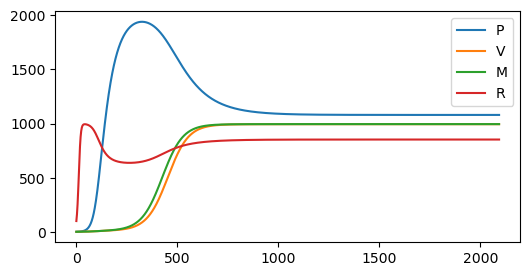

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot([np.sum(p) for p in P_hist], label = 'P')
ax.plot([np.sum(v) for v in V_hist], label = 'V')
ax.plot([np.sum(m) for m in M_hist], label = 'M')
ax.plot([r for r in R_hist], label='R')
ax.legend()

/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_14631/3486668093.py:2: RuntimeWarning: divide by zero encountered in log
  axes[0].pcolormesh(xv, yv, np.log(P), antialiased=False, cmap='magma')
/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_14631/3486668093.py:3: RuntimeWarning: divide by zero encountered in log
  axes[1].pcolormesh(xv, yv, np.log(V), antialiased=False, cmap='magma')
/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_14631/3486668093.py:3: RuntimeWarning: invalid value encountered in log
  axes[1].pcolormesh(xv, yv, np.log(V), antialiased=False, cmap='magma')
/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_14631/3486668093.py:4: RuntimeWarning: divide by zero encountered in log
  axes[2].pcolormesh(xv, yv, np.log(M), antialiased=False, cmap='magma')


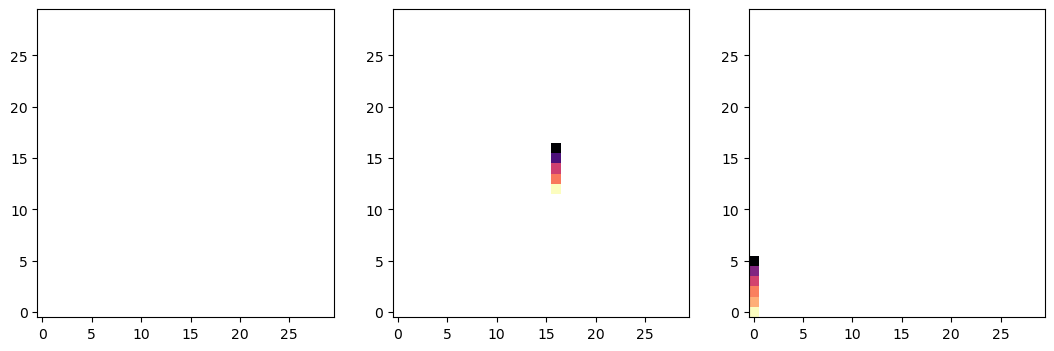

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(13,4))
axes[0].pcolormesh(xv, yv, np.log(P), antialiased=False, cmap='magma')
axes[1].pcolormesh(xv, yv, np.log(V), antialiased=False, cmap='magma')
axes[2].pcolormesh(xv, yv, np.log(M), antialiased=False, cmap='magma')

# axes[1].pcolormesh(xv, yv, (D.sum(axis=(0,1)) - (V + M)) / (V + M), antialiased=False, cmap='magma')
# axes[2].pcolormesh(xv, yv, np.log(V + M), antialiased=False, cmap='magma')

In [51]:
np.max(D)

2.569108011279178e-05

In [16]:
from matplotlib import animation
steps_per_frame = 10
fig, axes = plt.subplots(1, 3, figsize=(13,4))
# vmin=0
# vmax=5
nframes = len(P_hist)
def animate(i):
    # Remove old points
    for ax in axes:
        for artist in ax.get_lines()+ax.collections:
            artist.remove()

    t = i * steps_per_frame
    P_t = P_hist[t]
    V_t = V_hist[t]
    M_t = M_hist[t]
    for ax, pop in zip(axes, [P_t, V_t, M_t]):
        logpop = np.log(pop)
        # logpop[logpop < 0] = 0
        pcmap = ax.pcolormesh(xv, yv, logpop, 
                          antialiased=False, cmap='magma')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axes[0].set_title(r"Predator $d$")
    axes[1].set_title(r"Venomous $s$")
    axes[2].set_title(r"Mimic $s$")

    return ax.collections

anim = animation.FuncAnimation(fig, animate, 
                               frames= nframes//steps_per_frame, 
                               interval=50, blit=True)
plt.close()
anim.save('continuous_test.gif')

/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_5594/2102631928.py:18: RuntimeWarning: divide by zero encountered in log
  logpop = np.log(pop)
/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_5594/2102631928.py:18: RuntimeWarning: divide by zero encountered in log
  logpop = np.log(pop)
/var/folders/mp/32m29kq1643bw2wj_l7slh380000gn/T/ipykernel_5594/2102631928.py:18: RuntimeWarning: invalid value encountered in log
  logpop = np.log(pop)
